# Noise injection into models, ensemble

If you plan on using this implementation, please cite our work (\url{https://www.mdpi.com/2072-4292/13/8/1532}):

@Article{Nalepa2021RemoteSens,
AUTHOR = {Nalepa, Jakub and Myller, Michal and Cwiek, Marcin and
Zak, Lukasz and Lakota, Tomasz and
Tulczyjew, Lukasz and Kawulok, Michal},
TITLE = {Towards On-Board Hyperspectral Satellite Image Segmentation:
Understanding Robustness of Deep Learning through
Simulating Acquisition Conditions},
JOURNAL = {Remote Sensing},
VOLUME = {13},
YEAR = {2021},
NUMBER = {8},
ARTICLE-NUMBER = {1532},
URL = {https://www.mdpi.com/2072-4292/13/8/1532},
ISSN = {2072-4292},
DOI = {10.3390/rs13081532}}


Inject noise into the model's weights to create an augmented version. There are two scenarios were such operation could be useful:


- Model could be augmented N times, forming an ensemble. Each model makes its own predictions, which are then aggregated to conclude a final prediction. This noise injection into the model weights might be understood as a "regularization" of a trained model.
- Inject noise into the model to verify its robustness against unpredicted noise, which may occur due to rounding errors and floating point precision limitations (or other hardware-related issues), especially in models that have been quantized.

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import os

import tensorflow as tf

from ml_intuition.data.utils import plot_training_curve, show_statistics
from scripts import evaluate_model, prepare_data, artifacts_reporter, train_model

Specify path to the `.npy` dataset and ground truth, as well as the output path to store all the artifacts.

In [3]:
DEST_PATH = 'example_results'
DATA_FILE_PATH = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia.npy')
GT_FILE_PAT = os.path.join(os.path.dirname(os.getcwd()), 'datasets/pavia/pavia_gt.npy')
experiment_dest_path = os.path.join(DEST_PATH, 'experiment_0')
os.makedirs(experiment_dest_path, exist_ok=True)

# Prepare the data

To fit into the the pipeline, the data has to be preprocessed. It is achieved by the `prepare_data.main` function. It accepts a path to a `.npy` file with the original cube as well as the corresponding ground truth.  In this example, we randomly extract 250 samples from each class (balanced scenario), use 10% of them as validation set, and extract only spectral information of a pixel. The returned object is a dictionary with three keys: `train`, `test` and `val`. Each of them contains an additional dictionary with `data` and `labels` keys, holding corresponding `numpy.ndarray` objects with the data. For more details about the parameters, refer to the documentation of `prepare_data.main` function (located in `scripts/prepare_data`).

In [4]:
data = prepare_data.main(data_file_path=DATA_FILE_PATH,
                            ground_truth_path=GT_FILE_PAT,
                            output_path=None,
                            train_size=250,
                            val_size=0.1,
                            stratified=True,
                            background_label=0,
                            channels_idx=2,
                            neighborhood_size=None,
                            save_data=False,
                            seed=0)

# Train the original model 

The function `train_model.train` executed the trainig procedure. Trained model will be stored under `experiment_dest_path` folder path. For details about all arguments, please refer to the documentation of the `train_model.train` function (located in `scripts/train_model`).

In [5]:
train_model.train(model_name='model_2d',
                    kernel_size=5,
                    n_kernels=200,
                    n_layers=1,
                    dest_path=experiment_dest_path,
                    data=data,
                    sample_size=103,
                    n_classes=9,
                    lr=0.001,
                    batch_size=128,
                    epochs=200,
                    verbose=0,
                    shuffle=True,
                    patience=15,
                    noise=[],
                    noise_sets=[])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 1, 200)        1200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 200)        200200    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 1, 200)        200200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 1, 200)         200200    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               200200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
__________

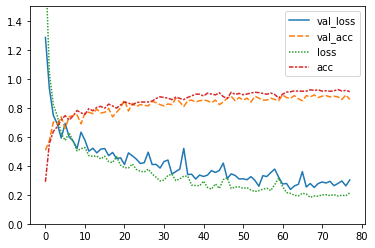

In [6]:
plot_training_curve(os.path.join(experiment_dest_path, "training_metrics.csv"), ['val_loss', 'val_acc', 'loss', 'acc'])

# Evaluate an ensemble of models

To use an ensemble of augmented models, provide a `use_ensemble` argument to `evaluate_model.evaluate` function. Indicate how many copies should be generated with `ensemble_copies` parameter. Lastly, indicate the voting algorithm. It accepts three values:

  
- **hard**          - uses predicted class labels for majority rule voting.
- **soft**          - predicts the class label based on the argmax of the sums of the predicted probabilities.
- **classifier**    - Use a classifier which accepts predicted probabilities from all the models as features and return the final prediction. The                            classifier is trained on the train set predictions. Random forest will be used.

  
Each layer is modified separately. It is achieved by drawing a random number for each of the parameters of the layer. The number is drawn from the normal distribution with provided mean and standard deviation calculated from the layer's parameters, multiplied by `0.1`.


In [ ]:
evaluate_model.evaluate(
    model_path=os.path.join(experiment_dest_path, 'model_2d'),
    data=data,
    dest_path=experiment_dest_path,
    n_classes=9,
    batch_size=1024,
    use_ensemble=True,
    ensemble_copies=4,
    voting='hard',
    noise=[],
    noise_sets=[],
    noise_params="{\"mean\": 0, \"std\": None}")
tf.keras.backend.clear_session()

In [8]:
show_statistics(os.path.join(experiment_dest_path, "inference_metrics.csv"))

,accuracy_score,balanced_accuracy_score,cohen_kappa_score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,inference_time
0,0.819128,0.892638,0.767129,0.794233,0.761509,0.886425,0.949893,0.996347,0.89705,0.968519,0.782634,0.997131,35.777774
